## Imports

In [22]:
import sys
import torch
import random
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

sys.path.append("../")
####### Dataset ############
from evaluation import main
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from coolname import generate_slug
from sklearn.metrics import accuracy_score

## Load dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[RandomCrop(size=(28, 28), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5)]
[Normalize(mean=[tensor(0.0053), tensor(0.0066), tensor(0.0077)], std=[tensor(1.0065), tensor(1.0080), tensor(1.0092)], inplace=False)]
[Normalize(mean=[tensor(0.0053), tensor(0.0066), tensor(0.0077)], std=[tensor(1.0065), tensor(1.0080), tensor(1.0092)], inplace=False)]


{'num_classes': 20,
 'input_shape': [50000, 3, 28, 28],
 'codename': 'Adaline',
 'benchmark': 89.85,
 'rand_augment': False}

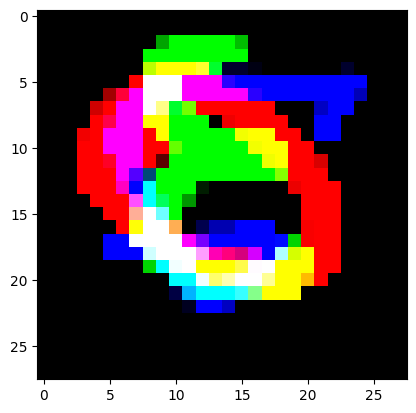

In [20]:
#Dataset must be in the folder datasets
# From https://github.com/Towers-D/NAS-Unseen-Datasets
Dataset="AddNIST"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = main.load_datasets(Dataset, truncate=False)
test_y = np.load(os.path.join('../datasets/'+Dataset,'test_y.npy'))
metadata["rand_augment"]=False
data_processor = DataProcessor(train_x, train_y, valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()


img=next(iter(train_loader))[0][0]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

metadata

## Search space

In [14]:
#metadata={"num_classes": 4, "input_shape": [49260, 3, 64, 64], "codename": "Caitie", "benchmark":47.008}
regnet_space=RegNet(metadata,
                    W0=[16, 64, 8],
                    WA=[8, 48, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,16,8], 
                    base_config="../configs/search_space/config.yaml")
print(regnet_space.cfg)

BN:
  EPS: 1e-05
  MOM: 0.1
  ZERO_INIT_FINAL_GAMMA: False
DESC: 
LN:
  EPS: 1e-05
MODEL:
  ACTIVATION_FUN: relu
  ACTIVATION_INPLACE: True
  NUM_CLASSES: 20
  SCALING_FACTOR: 1.0
  SCALING_TYPE: 
  TYPE: regnet
REGNET:
  BLOCK_TYPE: res_bottleneck_block
  BOT_MUL: 1.0
  DEPTH: 20
  DOWNSAMPLE: avg
  DROPOUT: 0.1
  DROP_RATE: 0.01
  GROUP_W: 8
  HEAD_W: 0
  SE_ON: True
  SE_R: 0.25
  STEM_TYPE: res_stem_cifar
  STEM_W: 28
  STRIDE: 2
  W0: 232
  WA: 115.89
  WM: 2.53


# Create model

In [15]:

# Folder to save the model
test_folder="test_dual_annealing"
# Config update is used to modify other parameter from the config
#config_updates=["REGNET.SE_ON", False]
#config_updates=["REGNET.DROP_RATE",0.05, "REGNET.DROPOUT",0.1]

config_updates=None
WA,W0,WM,DEPTH, Group_w=[48,56,2.4,12,8]
# if name is none, it creates a random name
model_name=generate_slug(2).replace("-", "_")
model, info=regnet_space.create_model(params=[float(WA),int(W0),float(WM),int(DEPTH), Group_w], save_folder=test_folder, name=model_name, gen=None, config_updates=config_updates)


Created model:  thundering_mastodon
res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'stem_type': 'res_stem_cifar', 'stem_w': 28, 'block_type': 'res_bottleneck_block', 'depths': [1, 3, 6, 2], 'widths': [56, 136, 320, 776], 'strides': [2, 2, 2, 2], 'bot_muls': [1.0, 1.0, 1.0, 1.0], 'group_ws': [8, 8, 8, 8], 'head_w': 0, 'se_r': 0.25, 'num_classes': 20, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
res_bottleneck_block


## Load model

In [9]:
model_name

'daring_crayfish'

In [11]:
# If already trained, add weights_file.
#weights_file=f"{test_folder}/{model_name}/student_best"

#model,info=regnet_space.load_model(config_file=f"{test_folder}/{model_name}/config.yaml",
#                                   weights_file=None)


res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'stem_type': 'res_stem_cifar', 'stem_w': 32, 'block_type': 'res_bottleneck_block', 'depths': [1, 3, 6, 2], 'widths': [56, 136, 320, 776], 'strides': [2, 2, 2, 2], 'bot_muls': [1.0, 1.0, 1.0, 1.0], 'group_ws': [8, 8, 8, 8], 'head_w': 0, 'se_r': 0, 'num_classes': 10, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
Loading model: test_dual_annealing/orchid_mink/config.yaml
res_bottleneck_block


In [7]:
from torchsummary import summary
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
      ResStemCifar-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 56, 64, 64]           3,584
       BatchNorm2d-6           [-1, 56, 64, 64]             112
              ReLU-7           [-1, 56, 64, 64]               0
            Conv2d-8           [-1, 56, 32, 32]           4,032
       BatchNorm2d-9           [-1, 56, 32, 32]             112
             ReLU-10           [-1, 56, 32, 32]               0
AdaptiveAvgPool2d-11             [-1, 56, 1, 1]               0
           Conv2d-12             [-1, 16, 1, 1]             912
             ReLU-13             [-1, 16, 1, 1]               0
           Conv2d-14             [-1, 5

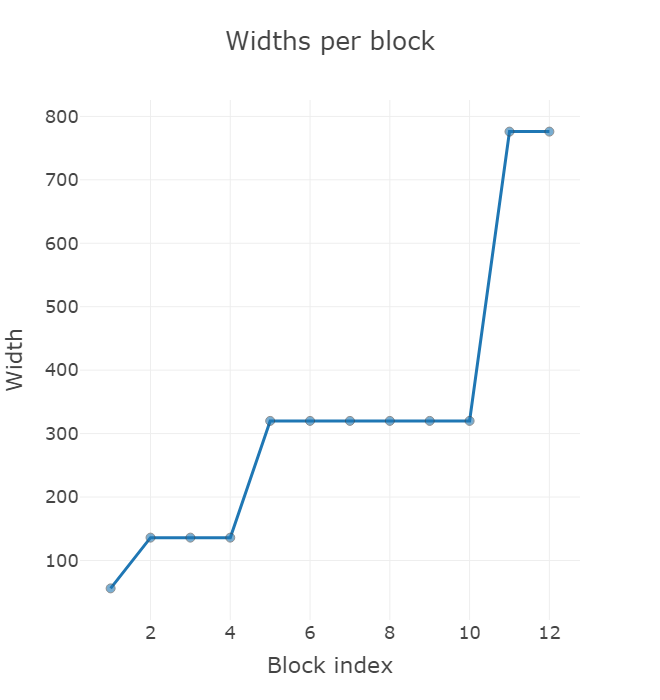

In [12]:
create_widths_plot({model_name:info})

## Train model

In [16]:
# Show train config file
metadata["train_config_path"]="../configs/train/vanilla_generation.yaml"
train_cfg=get_cfg()
train_cfg.merge_from_file(metadata["train_config_path"])
show_cfg(train_cfg)

[INFO] CONFIG:
DATASET:
  CLASSES: 0
  INPUT_SHAPE: []
  NUM_WORKERS: 2
  TEST:
    BATCH_SIZE: 64
  TYPE: ''
DISTILLER:
  STUDENT: null
  TEACHER: NONE
  TYPE: NONE
EXPERIMENT:
  LOGIT_STAND: false
  NAME: ''
  PROJECT: ''
SOLVER:
  BATCH_SIZE: 128
  EPOCHS: 1
  LABEL_SMOOTHING: 0.1
  LR: 0.025
  LR_SCHEDULER: cosine_annealing
  MOMENTUM: 0.9
  TOPK: 2
  TRAINER: base
  TYPE: SGD
  WARMUP: true
  WEIGHT_DECAY: 4.0e-05



In [17]:
clear_output(wait=True)
metadata["experiment_name"]=f"{test_folder}/{model_name}"
trainer=TrainerDistillation(model, device, train_loader, valid_loader, metadata) 
trainer.train()

[TRAIN] Epoch:1| Time(data):0.000| Time(train):0.057| Loss:2.8569| Top-1:11.275| Top-2:20.275: 100%|██████████| 703/703 [00:59<00:00, 11.76it/s]
[EVAL] Top-1:14.153| Top-2:23.753: 100%|██████████| 235/235 [00:06<00:00, 34.60it/s]


[EVAL] Best accuracy:14.15333366394043


RegNet(
  (stem): ResStemCifar(
    (conv): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (af): ReLU(inplace=True)
  )
  (s1): AnyStage(
    (b1): ResBottleneckBlock(
      (f): BottleneckTransform(
        (a): Conv2d(28, 56, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (a_af): ReLU(inplace=True)
        (b): Conv2d(56, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=7, bias=False)
        (b_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (b_af): ReLU(inplace=True)
        (se): SE(
          (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (f_ex): Sequential(
            (0): Conv2d(56, 7, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(7, 5

In [19]:
test_loader

In [23]:
predictions = trainer.predict(test_loader)
test_score = 100*accuracy_score(test_y, predictions)
print(test_score)